In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

Using plaidml.keras.backend backend.


In [2]:
train_data_directory = 'D:/data science/cats and dogs/train'

In [3]:
# image data preprocessing
image_size = (224,224)

batch_size = 32


class_mode = 'binary' # for multi-class classification problem, use: class_mode = 'category' 

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
#     rotation_range=90,
#     rescale=1./255,
#     shear_range=0.5,
#     zoom_range=0.5,
#     width_shift_range=0.5,
#     height_shift_range=0.5,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode="nearest",
    validation_split=0.2 # set validation split
    ) 

train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='validation') # set as validation data

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
# build a model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, GlobalAveragePooling2D

VGG_16 = Sequential()
VGG_16.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG_16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

VGG_16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

VGG_16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

VGG_16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

VGG_16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG_16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

VGG_16.add(Flatten())

VGG_16.add(Dense(4096,activation="relu"))
VGG_16.add(Dense(4096,activation="relu"))
VGG_16.add(Dense(1, activation="sigmoid"))

VGG_16.summary()

INFO:plaidml:Opening device "opencl_nvidia_geforce_rtx_3080.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       590080    
__________

In [5]:
# compile model
from keras import optimizers

VGG_16.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00005),
              metrics=['acc'])

In [6]:
# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("VGG16_dog_cat.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000000001)

In [7]:
# fit/train model

nb_epochs = 1000

history = VGG_16.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[checkpoint, early, learning_rate_reduction])

Epoch 1/1000
625/625 [==============================] - 540s 865ms/step - loss: 0.6323 - acc: 0.6320 - val_loss: 0.5653 - val_acc: 0.7023

Epoch 00001: val_acc improved from -inf to 0.70232, saving model to VGG16_dog_cat.h5
Epoch 2/1000
625/625 [==============================] - 537s 859ms/step - loss: 0.5338 - acc: 0.7329 - val_loss: 0.4850 - val_acc: 0.7647

Epoch 00002: val_acc improved from 0.70232 to 0.76469, saving model to VGG16_dog_cat.h5
Epoch 3/1000
625/625 [==============================] - 534s 855ms/step - loss: 0.4061 - acc: 0.8154 - val_loss: 0.3473 - val_acc: 0.8448

Epoch 00003: val_acc improved from 0.76469 to 0.84481, saving model to VGG16_dog_cat.h5
Epoch 4/1000
625/625 [==============================] - 533s 853ms/step - loss: 0.2798 - acc: 0.8815 - val_loss: 0.2744 - val_acc: 0.8810

Epoch 00004: val_acc improved from 0.84481 to 0.88104, saving model to VGG16_dog_cat.h5
Epoch 5/1000
625/625 [==============================] - 534s 855ms/step - loss: 0.2097 - acc: 0

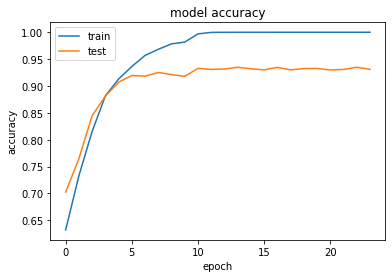

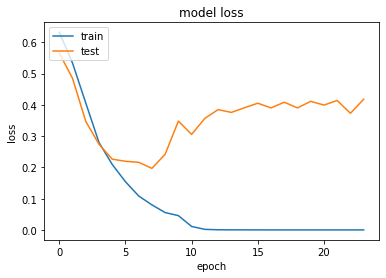

In [8]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()